<a href="https://colab.research.google.com/github/Thanos002/Anwendungen_KI/blob/main/BERTweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Model


In [72]:
"""
!git clone https://github.com/huggingface/transformers.git
%cd transformers/
!pip3 install --upgrade .
"""

'\n!git clone https://github.com/huggingface/transformers.git\n%cd transformers/\n!pip3 install --upgrade .\n'

In [73]:
!pip3 install emoji
!pip install transformers sentencepiece

In [74]:
def writeResultsInFile(accuracy, f1_score, random_seed):
    f = open("log", "a")
    f.write(f'Random seed : {random_seed}, accuracy : {accuracy}, f1-score : {f1_score}')
    f.close()


In [75]:
#imports hugging face
from transformers import AutoModel, AutoTokenizer

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization = True, use_fast=False)

In [76]:
import transformers
import torch
import html
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [98]:
class SATweetDataset(Dataset):

  def __init__(self, tweets, tokenizer, max_len, targets=None):
    self.tweets = tweets
    self.targets = targets if targets is not None else []
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    target = None
    tweet = str(self.tweets[item])
    if self.targets is not None and item < len(self.targets):
      target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation= True,
      return_token_type_ids=False,
      padding = 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    item_dict = {
        'tweet_text': tweet,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten()
    }

    # Include 'targets' in the dictionary only if they are available
    if target is not None:
        item_dict['targets'] = torch.tensor(self.targets[item], dtype=torch.long)

    return item_dict

In [78]:
def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = SATweetDataset(
        tweets=df.body.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [79]:
def create_test_data_loader(df, tokenizer, max_len, batch_size):

    ds = SATweetDataset(
        tweets=df.body.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [80]:
PRE_TRAINED_MODEL_NAME = "vinai/bertweet-base"

In [81]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = bertweet.from_pretrained(PRE_TRAINED_MODEL_NAME)
    #self.drop = nn.Dropout(p = 0.33)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    #output = self.drop(pooled_output)
    output = pooled_output
    return self.out(output)

In [82]:
def train_epoch(model, data_loader, loss_fn, optimizer,  device, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [83]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [84]:
def get_predictions(model, data_loader):
  model = model.eval()

  tweets_content = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      probs = nn.functional.softmax(outputs, dim=1)

      tweets_content.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
# Check if targets are available in the batch
      if 'targets' in d is not None:
        targets = d["targets"].to(device)
        real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  if real_values:
    real_values = torch.stack(real_values).cpu()
    return tweets_content, predictions, prediction_probs, real_values
  else:
    return tweets_content, predictions, prediction_probs

In [85]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [86]:
def avg_rec(y_test, y_pred):
    rec_n, rec_u, rec_p = recall_score(y_test, y_pred, average=None)
    return (1/3) * (rec_n+ rec_u+ rec_p)


In [87]:
def f1_np(y_test, y_pred):
    f1_n, _,f1_p = f1_score(y_test, y_pred, average=None)
    return 0.5*(f1_n+f1_p)



####Bonus 2024

In [88]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
df_Bonus_train = pd.read_csv('/content/drive/My Drive/train.csv', names = ['id', 'body', 'target'], header=0)
df_Bonus_test = pd.read_csv('/content/drive/My Drive/test_no_label.csv', names = ['id', 'body', 'target'], header=0)
df_Bonus_train['body'] = df_Bonus_train['body'].apply(html.unescape)
df_Bonus_train

,id,body,target
0,0,#anywere “@TheCooleyShow: LA = palm trees and ...,1
1,1,RT @OfficialA1King: The face you make when you...,1
2,2,bitch get off my twitter hoe 👊,1
3,3,I can taste loud n pussy on my tongue 😝,1
4,4,Diabetes galore 😂😂😂😂😂 RT @TIME: Colorado healt...,2
...,...,...,...
19821,19821,RT @_BredDIFFERENT: Niggas will fuck yah good ...,1
19822,19822,Soft niggas usually send the hate threw the bi...,1
19823,19823,RT @_POCAPetite: stick by his side and don't g...,1
19824,19824,RT @Blakeanthony98: “@Thompson_Era: “@hiagokou...,1


In [90]:
df_Bonus_train['target'] = df_Bonus_train['target'].astype(int)

In [91]:
token_lens = []
for txt in df_Bonus_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


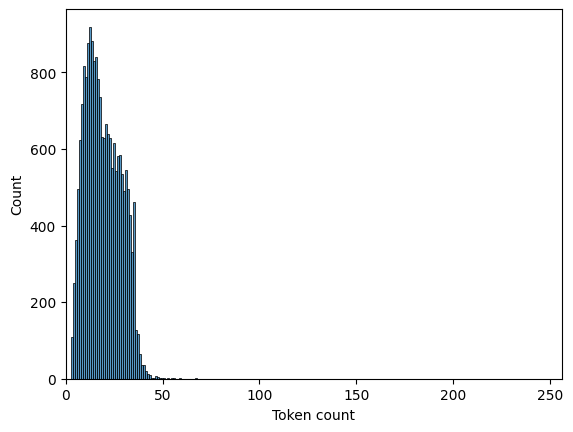

In [92]:
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [93]:
MAX_LEN = max(token_lens)
BATCH_SIZE = 32

In [94]:
MAX_LEN

68

In [95]:
RANDOM_SEED = 1993
df_train, df_val = train_test_split(df_Bonus_train, test_size=0.1, random_state=RANDOM_SEED)
df_test = df_Bonus_test

In [100]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [101]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [102]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [103]:
n_classes = 3
class_names = ['hate', 'offensive', 'neither']

In [104]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 68])
torch.Size([32, 68])


In [105]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [134]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [135]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'bertweet_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.3365930501425031 accuracy 0.8868463823348092


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val   loss 0.2077772483349808 accuracy 0.9258698940998488

Epoch 2/30
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.2190734198697472 accuracy 0.9241158997926359


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val   loss 0.20152989504558425 accuracy 0.9263741805345437

Epoch 3/30
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.18646092365385705 accuracy 0.9360533542565712


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val   loss 0.22030600490829638 accuracy 0.9152798789712557

Epoch 4/30
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.15609754769525433 accuracy 0.9445721011040745


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val   loss 0.2527633553911601 accuracy 0.9062027231467474

Epoch 5/30
----------
Train loss 0.12136832982849156 accuracy 0.9579667096340302


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val   loss 0.32396590048747675 accuracy 0.8925869894099849

Epoch 6/30
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.08864926888881164 accuracy 0.9706887855181304


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val   loss 0.30315390510124063 accuracy 0.9072112960161373

Epoch 7/30
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.06379361381156765 accuracy 0.9781426890096957


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val   loss 0.36348947616774707 accuracy 0.897629853756934

CPU times: user 25min 22s, sys: 16.3 s, total: 25min 38s
Wall time: 25min 16s


In [136]:
model.load_state_dict(torch.load('bertweet_best_model_state.bin'))

<All keys matched successfully>

In [137]:
test_data_loader = create_test_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [138]:
model.eval()
y_tweet_texts, y_pred, y_pred_probs = get_predictions(
  model,
  test_data_loader
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [141]:
y_pred_list = y_pred.tolist()
assert len(y_pred_list) == len(df_test), "Length of predictions does not match the number of tweets in the DataFrame."
df_test['Prediction'] = y_pred_list
df_test.to_csv('/content/drive/My Drive/test_labeled.csv', index=False)


In [140]:
# Get predictions for the validation set
_, val_predictions, _, val_labels = get_predictions(model, val_data_loader)

# Generate classification report
report = classification_report(val_labels, val_predictions)
print(report)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

           0       0.50      0.48      0.49       104
           1       0.95      0.96      0.96      1539
           2       0.94      0.89      0.92       340

    accuracy                           0.93      1983
   macro avg       0.80      0.78      0.79      1983
weighted avg       0.93      0.93      0.93      1983

